In [1]:
import os
if os.getcwd().replace("\\", "/").split("/")[-1] in ["notebooks", "scripts"]:
    os.chdir("..")


# the model

In [2]:
import duckdb
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [3]:
table = "sandbox_T_apartment_S_ca"
con = duckdb.connect("data/exploitation.db", read_only=True)

X_train = con.execute(f"select * from {table}_X_train_processed").df()
y_train = con.execute(f"select * from {table}_y_train_processed").df()
X_val = con.execute(f"select * from {table}_X_test_processed").df()
y_val = con.execute(f"select * from {table}_y_test_processed").df()

con.close()

## model training

In [4]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [5]:
def printMetrics(y_true, y_pred):
    print("RMSE: ", round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 4))
    print("MAE: ", round(metrics.mean_absolute_error(y_true, y_pred),4))
    print("MAPE: ", round(metrics.mean_absolute_percentage_error(y_true, y_pred),4))
    print("R2: ", round(metrics.r2_score(y_true, y_pred),4))

### option 1-1 - linear regression (without regularization)

In [6]:
reg = LinearRegression().fit(X_train, y_train)
yhat_train_lin = reg.predict(X_train)
yhat_val_lin = reg.predict(X_val)

In [7]:
printMetrics(y_train, yhat_train_lin)
print()
printMetrics(y_val, yhat_val_lin)

RMSE:  0.2018
MAE:  0.1429
MAPE:  0.0193
R2:  0.7047

RMSE:  0.1975
MAE:  0.1427
MAPE:  0.0193
R2:  0.7214


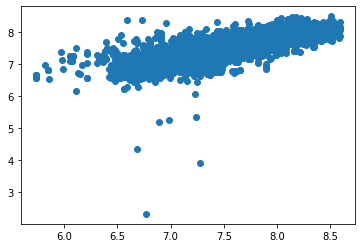

In [8]:
plt.scatter(y_train, yhat_train_lin)

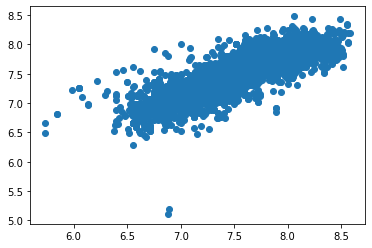

In [9]:
plt.scatter(y_val, yhat_val_lin)

### option 1-2 - ridge regression
it uses leave-one-out cross-validation to tune the regularization parameter

In [10]:
rreg = RidgeCV(alphas = np.logspace(-3,3,7)).fit(X_train, y_train)

In [11]:
rreg.score(X_train, y_train)

0.584345854494865

In [12]:
yhat_train_rr = rreg.predict(X_train)
yhat_val_rr = rreg.predict(X_val)

In [13]:
rreg.get_params()

{'alpha_per_target': False,
 'alphas': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'cv': None,
 'fit_intercept': True,
 'gcv_mode': None,
 'normalize': 'deprecated',
 'scoring': None,
 'store_cv_values': False}

In [14]:
rreg.alpha_

0.1

In [15]:
printMetrics(y_train, yhat_train_rr)
print()
printMetrics(y_val, yhat_val_rr)

RMSE:  0.2394
MAE:  0.1771
MAPE:  0.0238
R2:  0.5843

RMSE:  0.2376
MAE:  0.1779
MAPE:  0.0239
R2:  0.5969


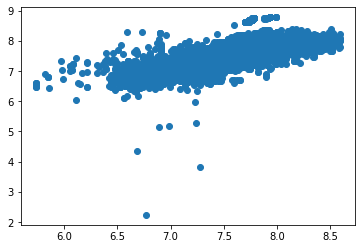

In [18]:
plt.scatter(y_train, yhat_train_rr)

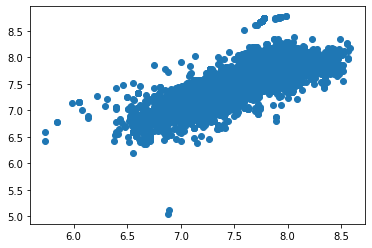

In [19]:
plt.scatter(y_val, yhat_val_rr)

### option 1-3 - lasso regression

In [20]:
lreg = LassoCV(alphas = np.logspace(-3,3,7)).fit(X_train, y_train)

c:\Users\adria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\adria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331.40230373689536, tolerance: 0.2042997341586239
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\adria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337.8406317386524, tolerance: 0.20847795356023782
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\adria\AppData\

In [21]:
lreg.score(X_train, y_train)

0.6945910117667913

In [22]:
yhat_train_lr = lreg.predict(X_train)
yhat_val_lr = lreg.predict(X_val)

In [23]:
lreg.get_params()

{'alphas': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'copy_X': True,
 'cv': None,
 'eps': 0.001,
 'fit_intercept': True,
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': 'auto',
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

In [24]:
lreg.alpha_

0.001

In [25]:
printMetrics(y_train, yhat_train_lr)
print()
printMetrics(y_val, yhat_val_lr)

RMSE:  0.2052
MAE:  0.1444
MAPE:  0.0195
R2:  0.6946

RMSE:  0.1995
MAE:  0.144
MAPE:  0.0195
R2:  0.7157


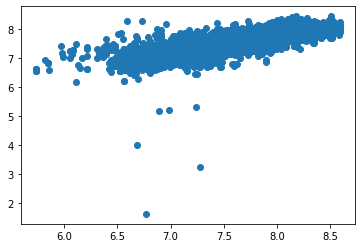

In [26]:
plt.scatter(y_train, yhat_train_lr)

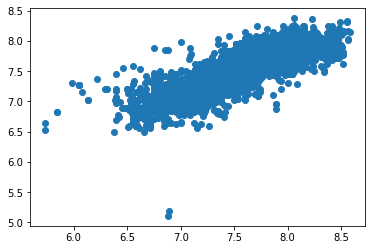

In [27]:
plt.scatter(y_val, yhat_val_lr)

### option 2 - random forest
random forest from scikit-learn library, with the default parameters

In [28]:
rf = RandomForestRegressor(oob_score=True).fit(X_train, y_train)

C:\Users\adria\AppData\Local\Temp\ipykernel_7748\1047091557.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestRegressor(oob_score=True).fit(X_train, y_train)


In [29]:
yhat_train_rf = rf.predict(X_train)
yhat_val_rf = rf.predict(X_val)

In [30]:
printMetrics(y_train, yhat_train_rf)
print()
printMetrics(y_val, yhat_val_rf)

RMSE:  0.0426
MAE:  0.0213
MAPE:  0.0029
R2:  0.9868

RMSE:  0.095
MAE:  0.0456
MAPE:  0.0061
R2:  0.9356


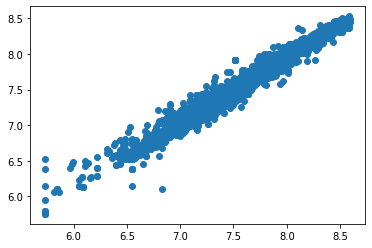

In [31]:
plt.scatter(y_train, yhat_train_rf)

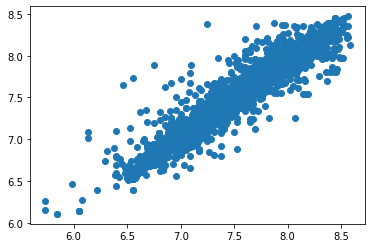

In [32]:
plt.scatter(y_val, yhat_val_rf)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

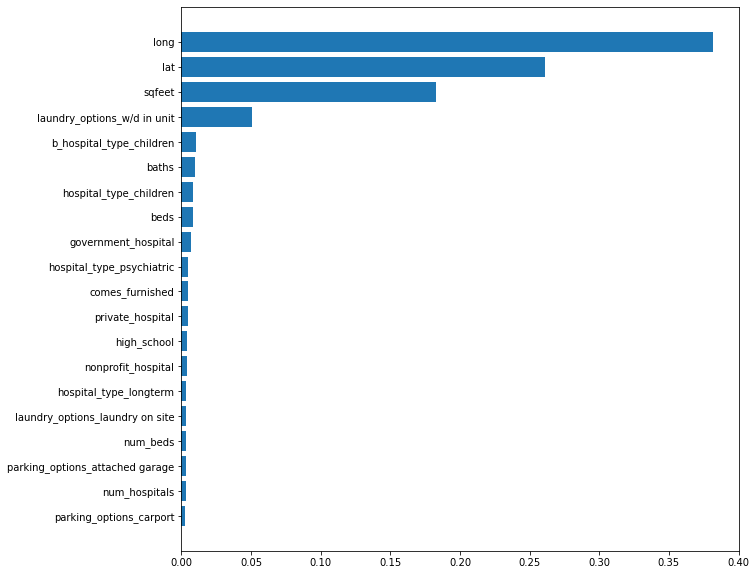

In [33]:
# top 20 feature importance
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(rf.feature_names_in_[sorted_idx][-20:], rf.feature_importances_[sorted_idx][-20:])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [34]:
from sklearn.tree import plot_tree

[Text(0.5, 0.875, 'lat <= 34.469\nsquared_error = 0.137\nsamples = 11951\nvalue = 7.428'),
 Text(0.25, 0.625, 'sqfeet <= 6.83\nsquared_error = 0.088\nsamples = 5239\nvalue = 7.585'),
 Text(0.125, 0.375, 'long <= -117.601\nsquared_error = 0.067\nsamples = 3112\nvalue = 7.47'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'long <= -116.381\nsquared_error = 0.07\nsamples = 2127\nvalue = 7.757'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'long <= -121.822\nsquared_error = 0.14\nsamples = 6712\nvalue = 7.307'),
 Text(0.625, 0.375, 'lat <= 38.896\nsquared_error = 0.159\nsamples = 1282\nvalue = 7.781'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'laundry_options_w/d in unit <= 0.5\nsquared_error = 0.072\nsamples = 5430\nvalue = 7.198'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

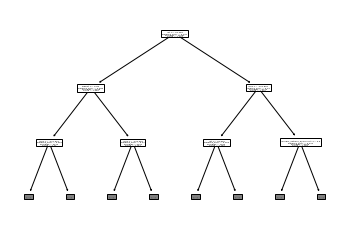

In [35]:
# plot of one of the trees of the random forest
# cut at 2 levels, for visualization
plot_tree(rf.estimators_[0], max_depth=2, feature_names=rf.feature_names_in_)

### option 3 - xgboost

#### without hyperparameter tunning

In [34]:
#!pip install -U xgboost --quiet

In [36]:
import xgboost as xgb

In [37]:
param = {
    'objective':'reg:squarederror',
    'verbosity':1,
    'learning_rate':0.3,
    'max_depth':10,
    'subsample':0.8, # to avoid overfitting
    'reg_lambda':0.1, # L2 reg
    'alpha':0, #L1 reg
    'max_leaves':10
}
n_estim = 20

In [38]:
data_train = xgb.DMatrix(X_train, label=y_train)
data_val = xgb.DMatrix(X_val, label=y_val)

In [39]:
time0 = time()
xgb_1 = xgb.train(param, data_train, n_estim)
print(time()-time0)

1.2706191539764404


In [40]:
yhat_train_xgb1 = xgb_1.predict(data_train)
yhat_val_xgb1 = xgb_1.predict(data_val)

In [41]:
printMetrics(y_train, yhat_train_xgb1)
print()
printMetrics(y_val, yhat_val_xgb1)

RMSE:  0.0607
MAE:  0.0418
MAPE:  0.0056
R2:  0.9733

RMSE:  0.1069
MAE:  0.0614
MAPE:  0.0082
R2:  0.9184


In [42]:
from xgboost import plot_importance, plot_tree

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

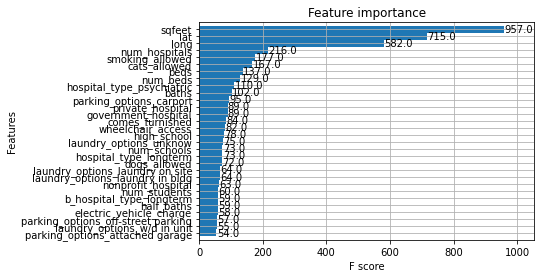

In [43]:
plot_importance(xgb_1, max_num_features = 30, height = 1)

In [44]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50

In [ ]:
try:
    #plt.figure(figsize=(10,10))
    xgb.plot_tree(xgb_1, num_trees = 4, rankdir="LR")
except:
    pass

In [ ]:
# if the previous cell (plot_tree) doesn't work, install graphviz from here and add it to the path:

#https://graphviz.org/download/
#import os
#os.environ["PATH"] += os.pathsep+'C:/Program Files (x86)/Graphviz/bin'

#### with hyperparameter tunning

In [50]:
from sklearn.model_selection import GridSearchCV

In [51]:
params = {
    #'objective':'reg:squarederror',
    #'verbosity':1,
    'learning_rate':[0.1, 0.3, 1],
    'max_depth':[5, 7, 10],
    'subsample':[0.8], # to avoid overfitting
    'reg_lambda':[0, 0.1, 1], # L2 reg
    'alpha':[0, 0.1, 1], #L1 reg
    'max_leaves':[10],
    'n_estimators':[5, 10, 20]
}


In [52]:
xgbr = xgb.XGBRegressor(seed = 20, objective = 'reg:squarederror', verbosity = 1)

time0 = time()
xgb_grid = GridSearchCV(estimator=xgbr, param_grid = params, cv = 3)
xgb_grid.fit(X_train, y_train)
# retrain with the best parameters:
xgb_cv = xgb.train(xgb_grid.best_params_, data_train, xgb_grid.best_params_['n_estimators'])

print(time()-time0) # time ~ 443s

[21:34:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

295.40931487083435


In [53]:
"""{'alpha': 0,
 'learning_rate': 0.3,
 'max_depth': 10,
 'max_leaves': 10,
 'n_estimators': 20,
 'reg_lambda': 0,
 'subsample': 0.8}"""
xgb_grid.best_params_

{'alpha': 0,
 'learning_rate': 0.3,
 'max_depth': 10,
 'max_leaves': 10,
 'n_estimators': 20,
 'reg_lambda': 0,
 'subsample': 0.8}

In [54]:
yhat_train_xgbcv = xgb_cv.predict(data_train)
yhat_val_xgbcv = xgb_cv.predict(data_val)

In [55]:
printMetrics(y_train, yhat_train_xgbcv)
print("")
printMetrics(y_val, yhat_val_xgbcv)

RMSE:  0.0468
MAE:  0.0314
MAPE:  0.0042
R2:  0.9841

RMSE:  0.1003
MAE:  0.0546
MAPE:  0.0073
R2:  0.9282


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

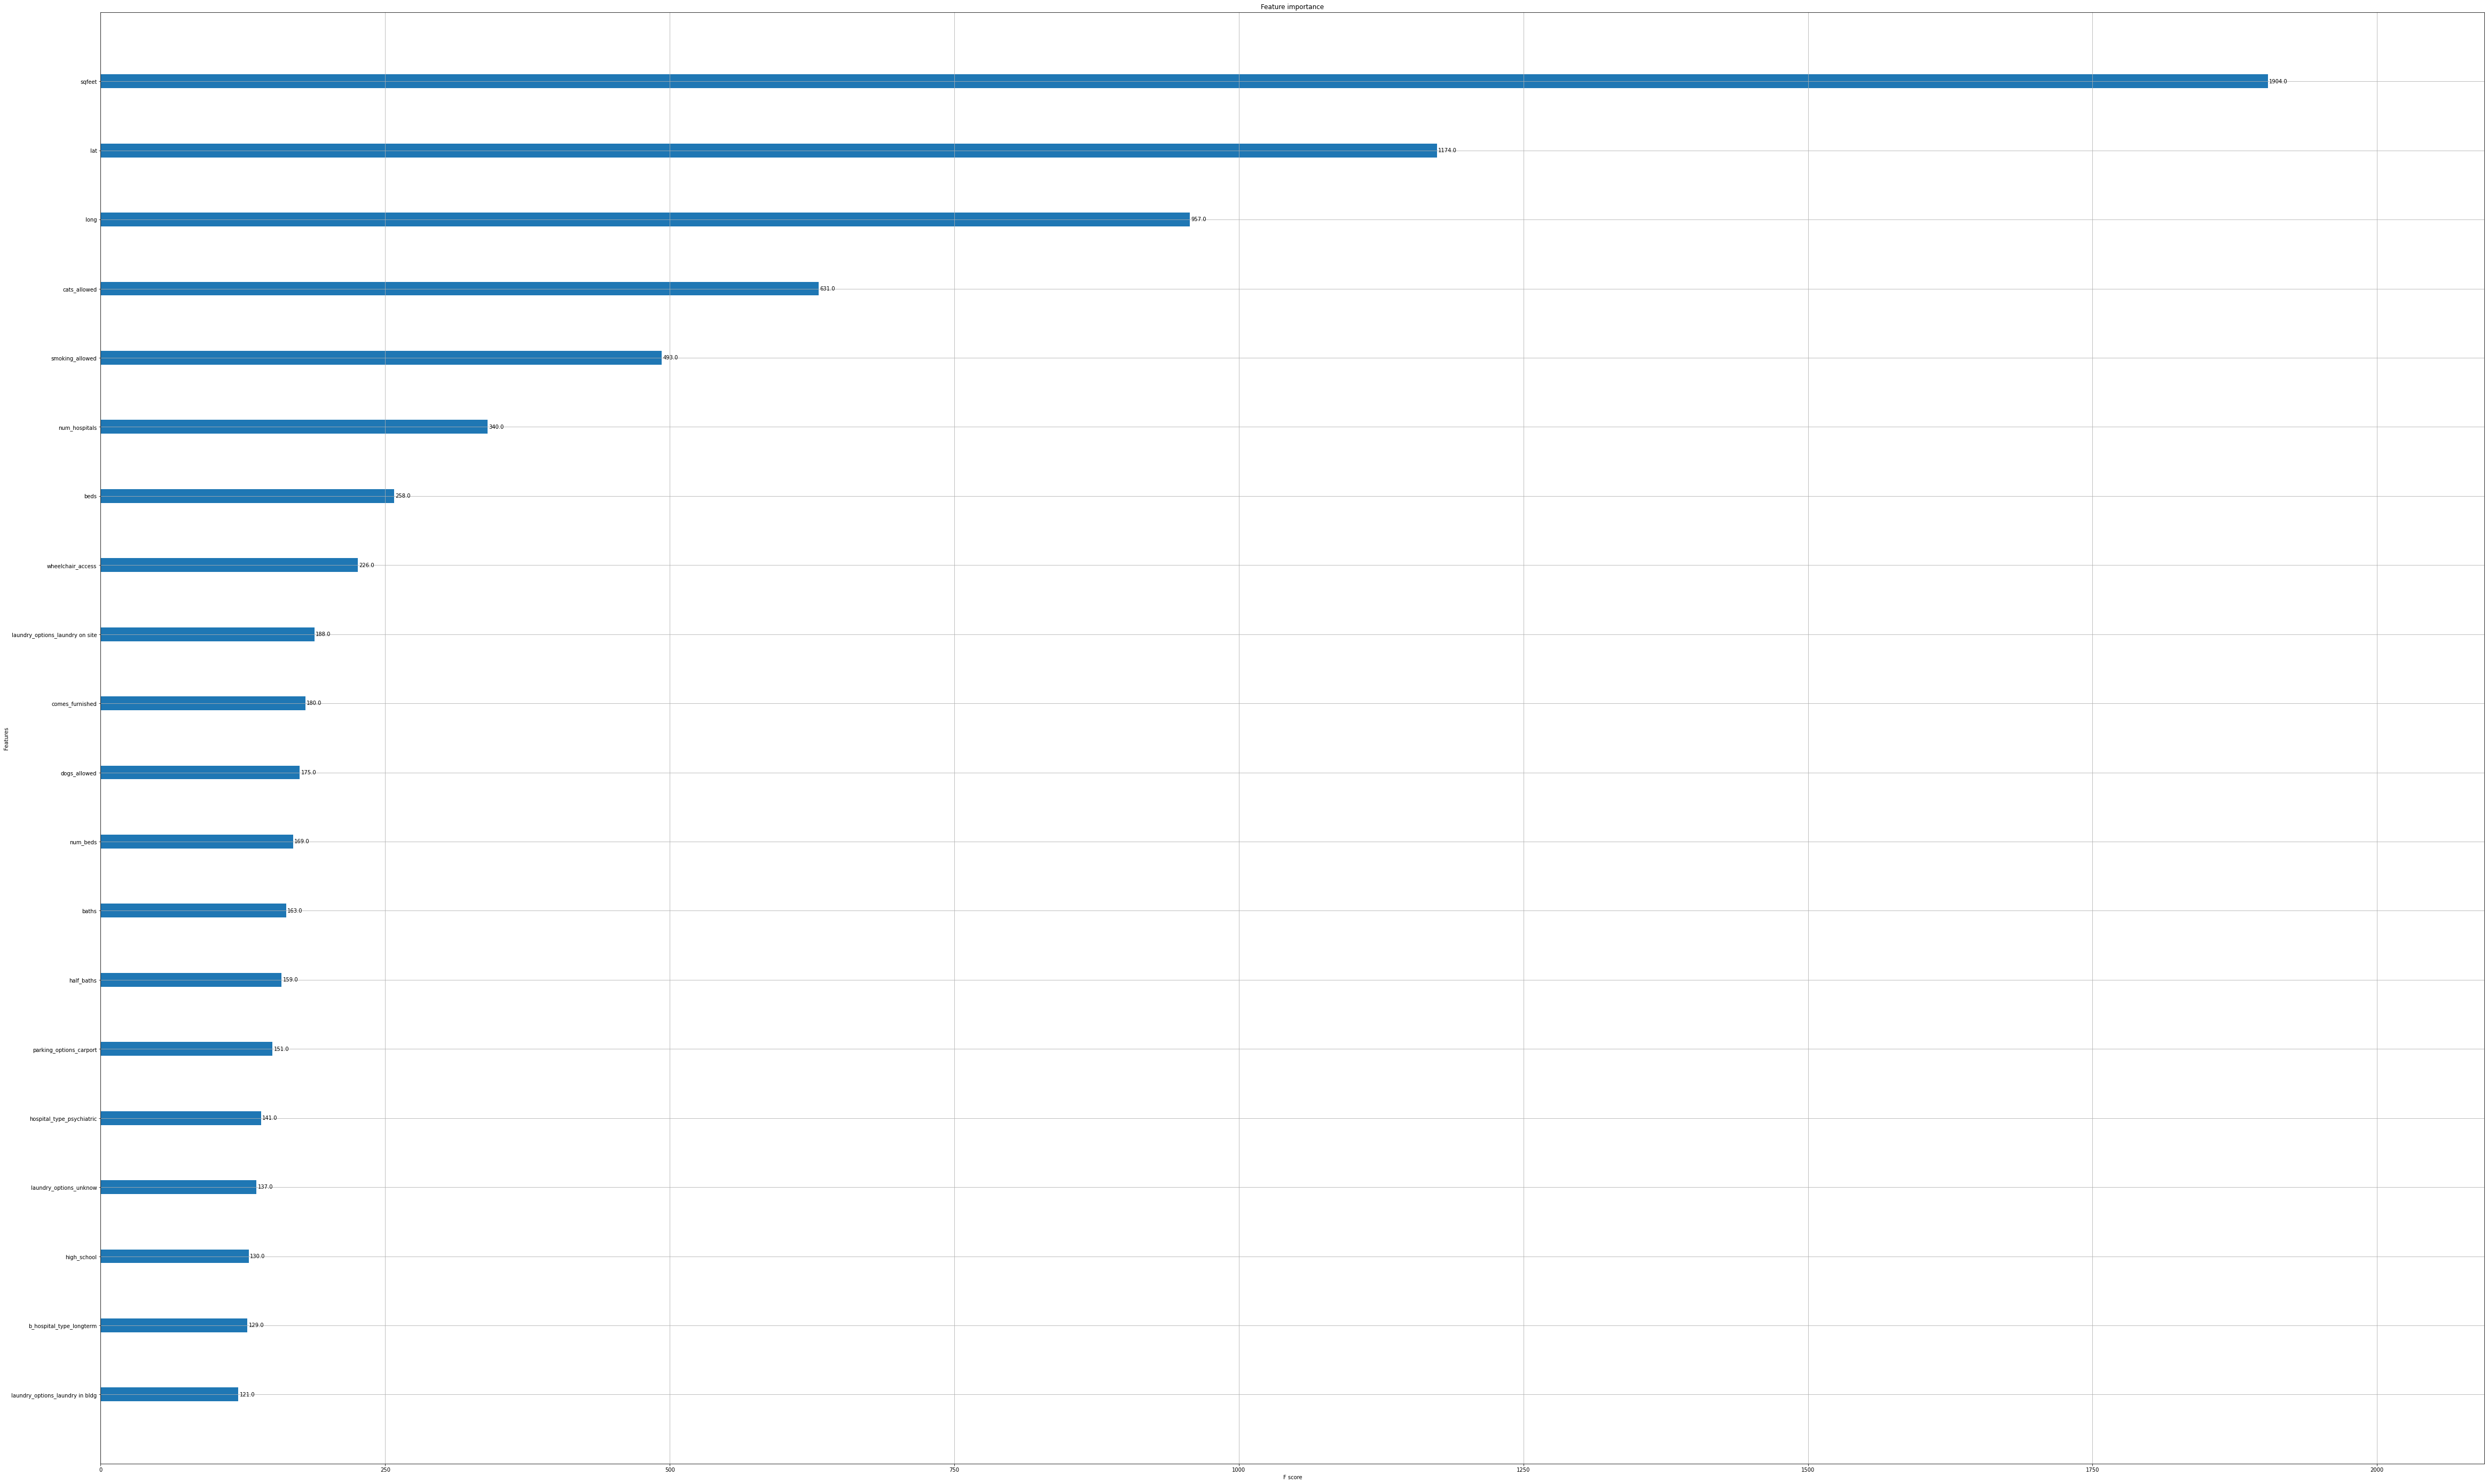

In [56]:
plot_importance(xgb_cv, max_num_features=20)

# plots

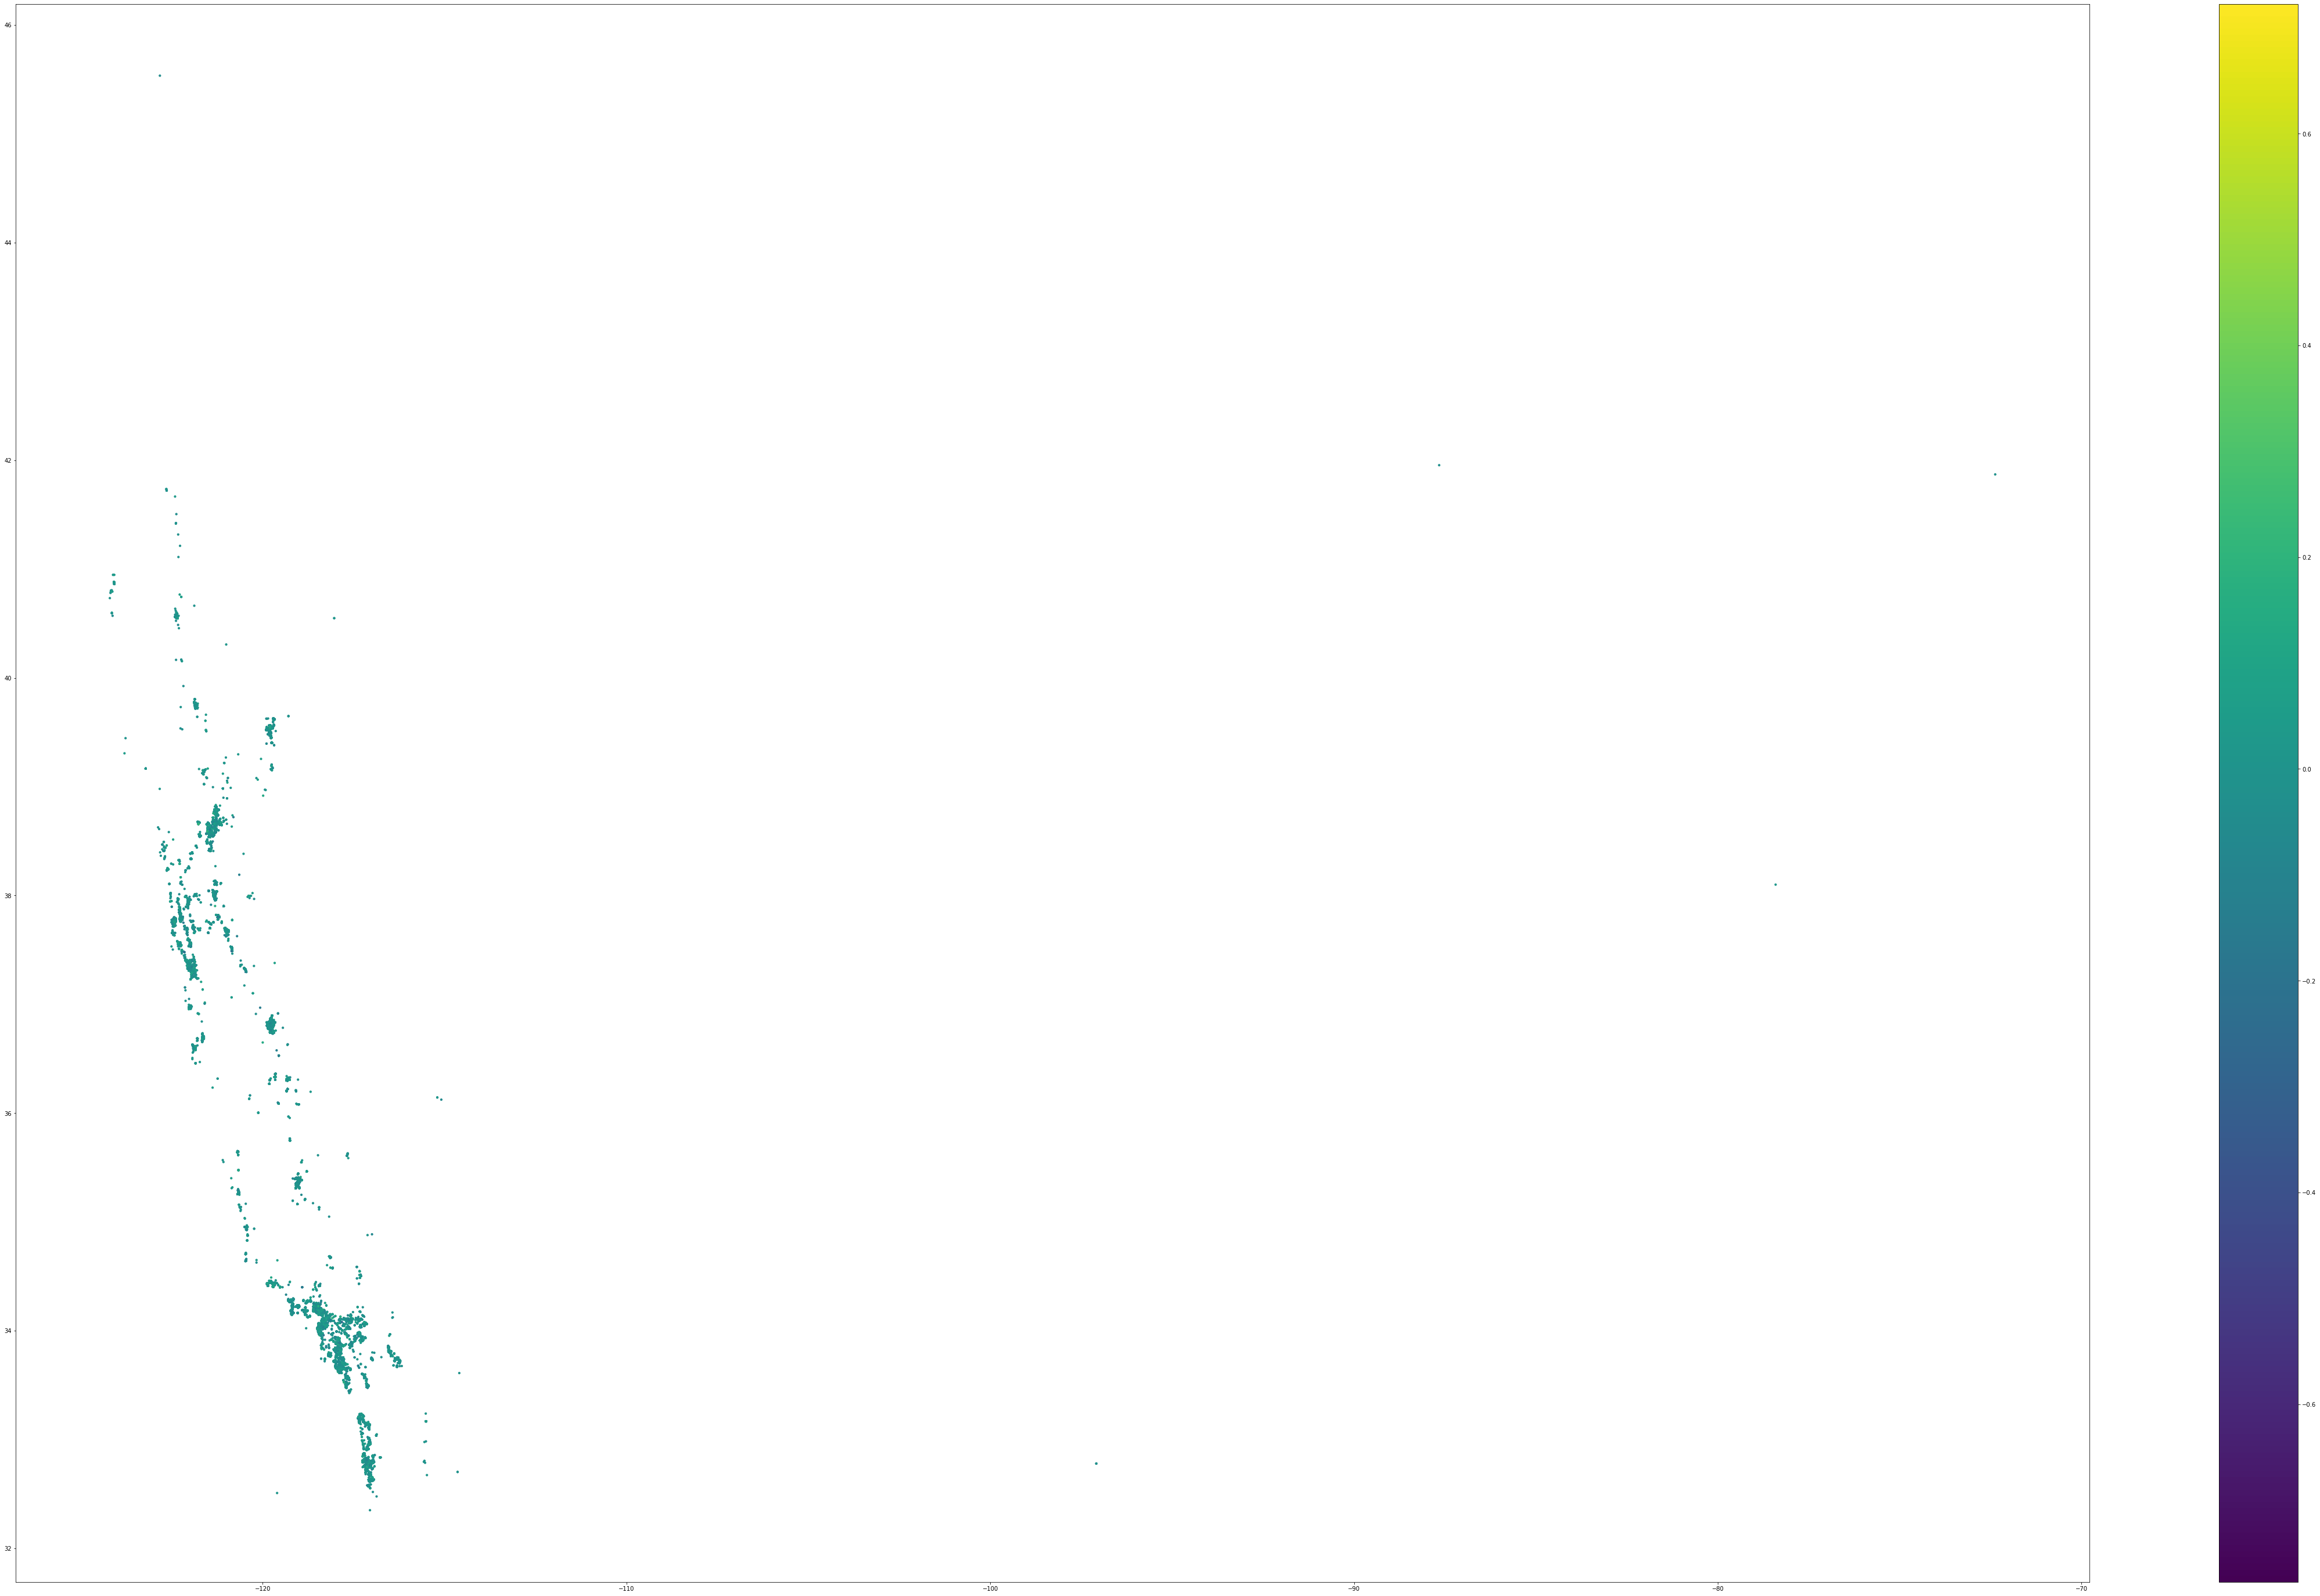

In [70]:
plt.scatter(X_train.long, X_train.lat, c=y_train.price-yhat_train_xgbcv, s=10)
plt.colorbar()

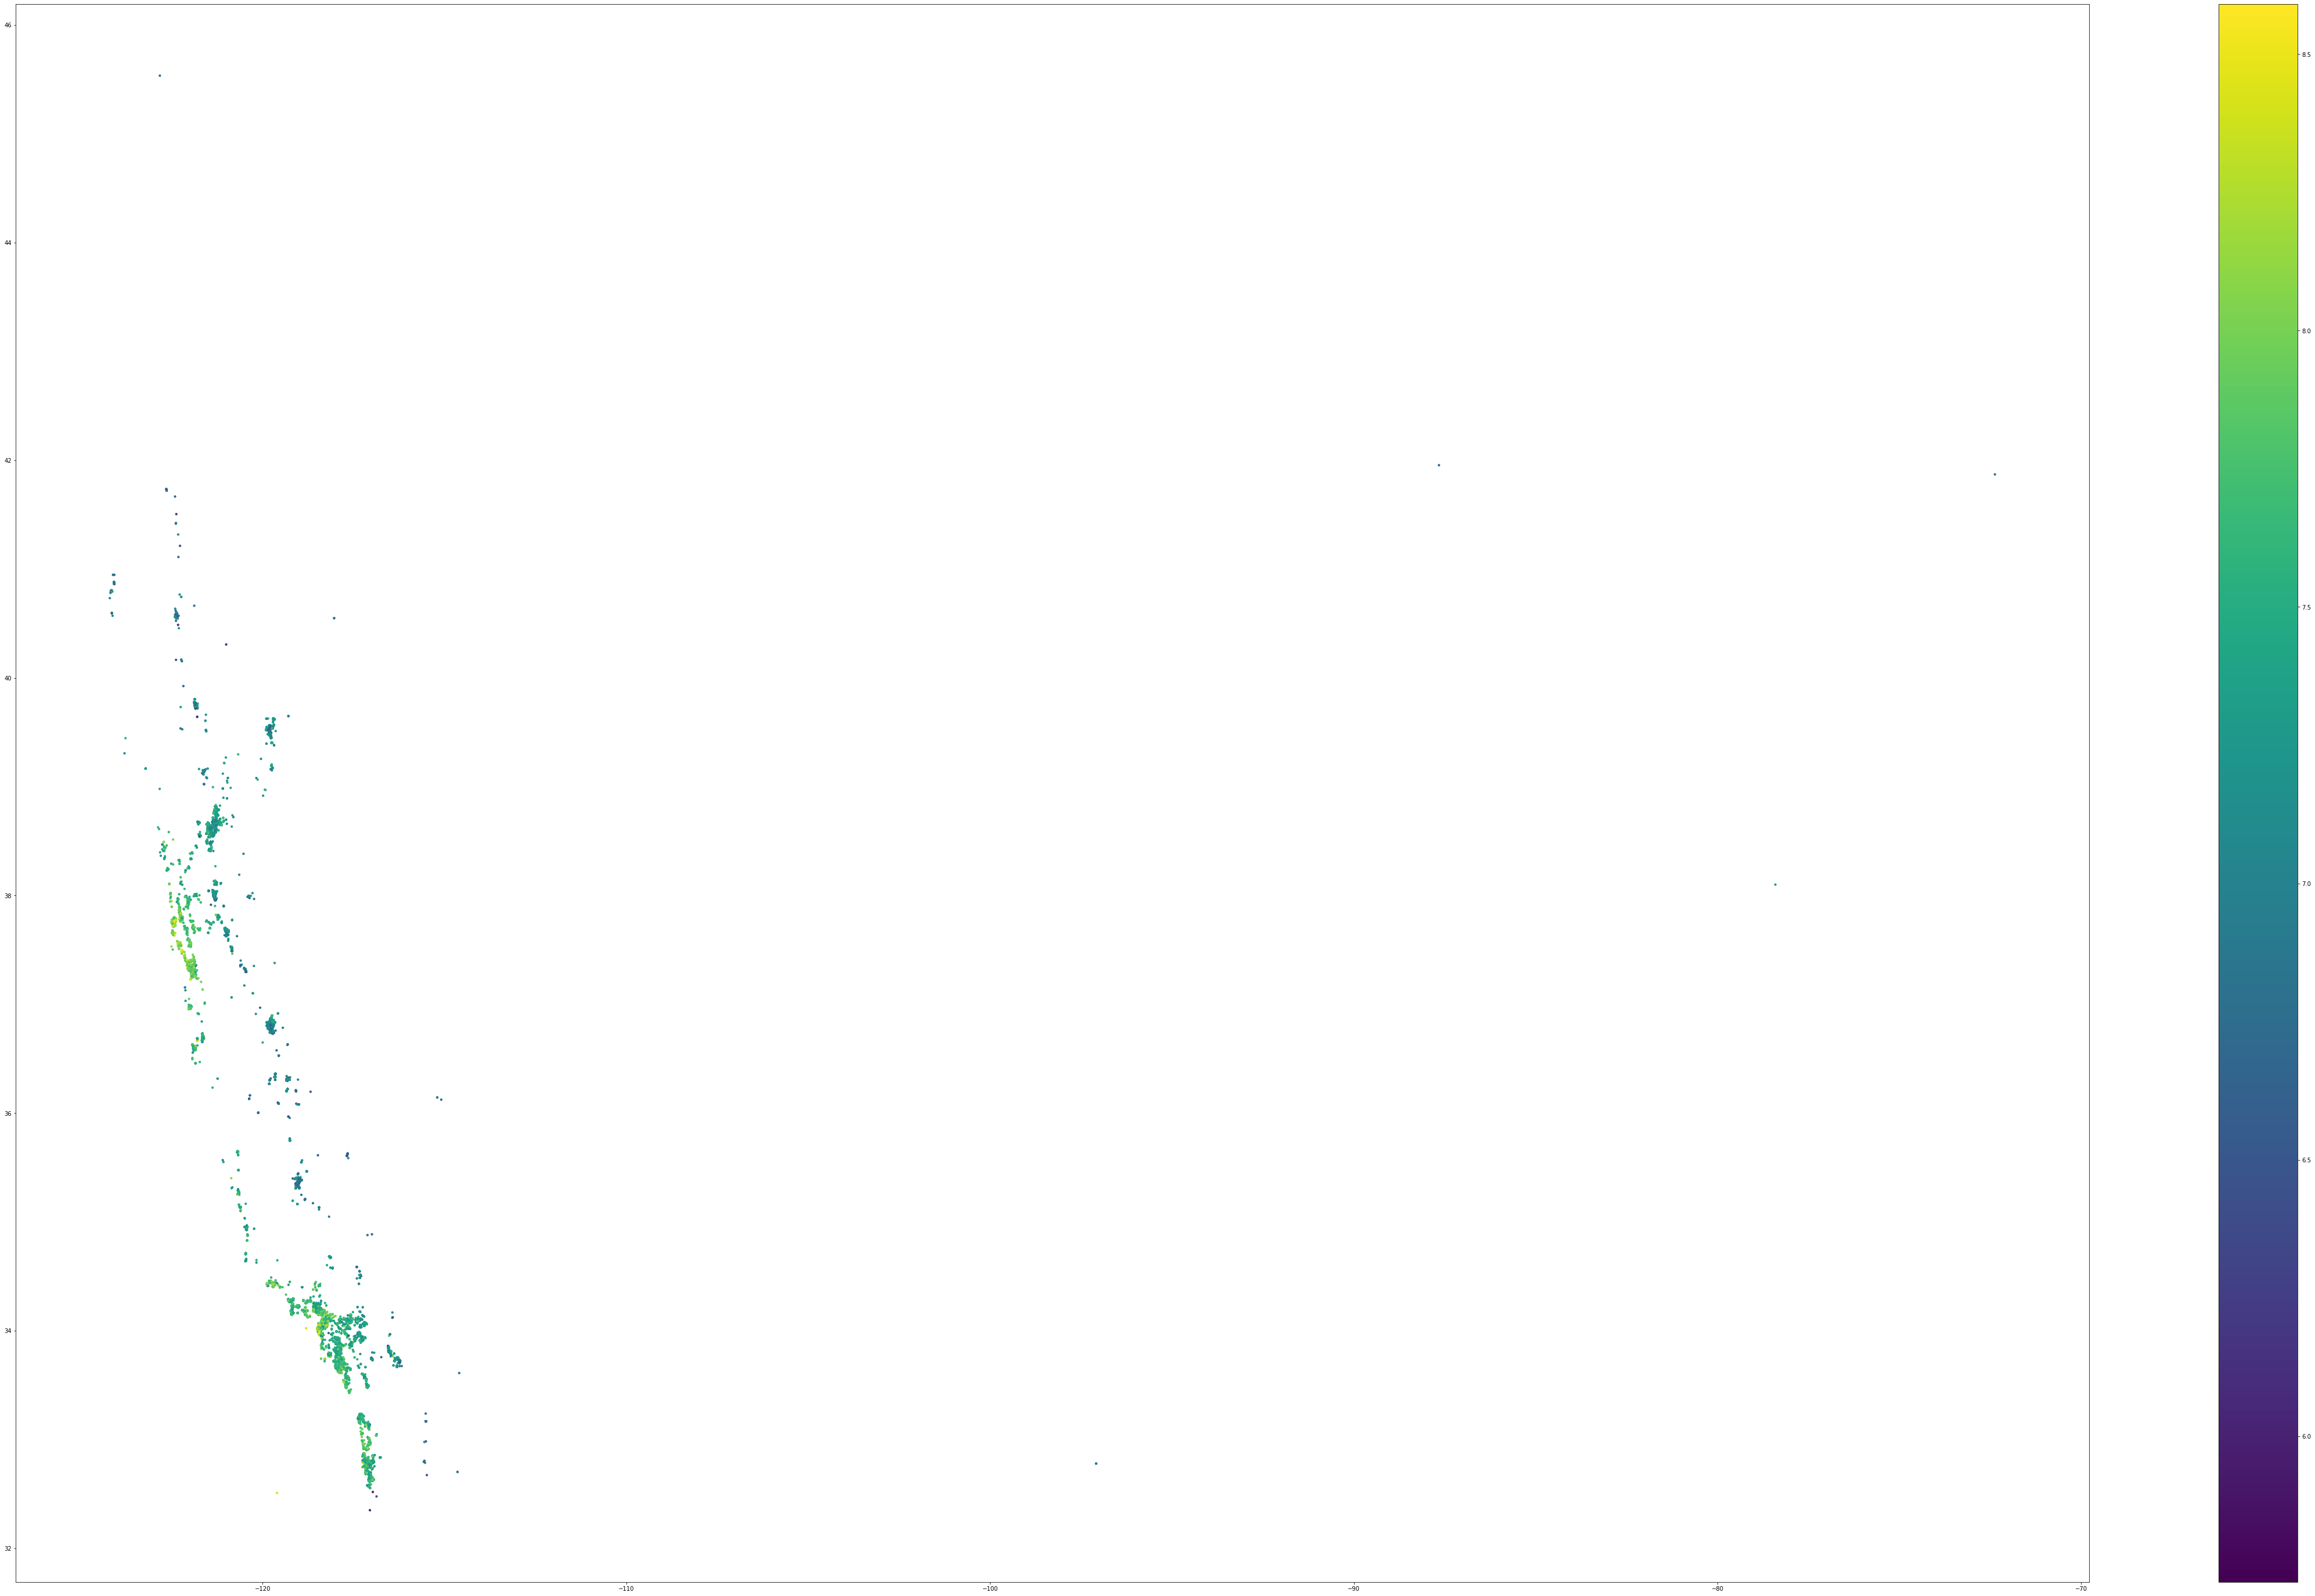

In [71]:
plt.scatter(X_train.long, X_train.lat, c=y_train.price, s=10)
plt.colorbar()